In [1]:
%matplotlib inline
import future
import pylab as plt
import numpy as np
from scipy.spatial import cKDTree
from bornagain import Molecule
from thor import scatter
import mdtraj
from scipy.spatial import distance
from bornagain.simulate import refdata

In [2]:
from loki.utils.postproc_helper import is_outlier

def single_atom_dens(atomic_num, grid_size=3, grid_spacing=0.05,
                    filter_atomic_core=True, filter_thresh=50, 
                    filter_sig=5):
    """
    atomic_num, atomic number of element 
    grid_size, size of cubic density grid in Angstrom
    grid_spacing, spacing of cubic grid in Angstrom
    filter_atomic_core, whether to filter the faulty density at atomic core
    """
    #print atomic_num
    Ngrid_pt = int( float(grid_size)/grid_spacing)

    vals = np.arange( -Ngrid_pt/2, Ngrid_pt/2)  * grid_spacing #, grid_spacing)
    
    x,y,z = np.meshgrid( vals,vals,vals, sparse=True)
    R = np.sqrt( x**2 + y**2 + z**2 )
    R1 = R.ravel()

    rho = np.zeros( R1.shape).astype(np.float32)
    
    # this bit makes the form factor
    cromermann = refdata.get_cromermann_parameters( [atomic_num])[atomic_num]
    xo = 4.0 * (np.pi ** 2) * np.power( R1 , 2)
    for i in range(4):    
        rho += cromermann[i] * np.exp(-xo/cromermann[i+4])\
            / np.power(cromermann[i+4], 0.5 )
    
    rho *=  2 * np.sqrt(2) * np.pi

    if filter_atomic_core:
        dm = rho[ rho > 0].mean()
        s = rho [ rho > 0].std()

        idx = np.where( rho > dm+filter_sig*s)[0]
        vals = rho[ idx]
        bad = is_outlier( vals, filter_thresh)
        fillvalue = vals[~bad].max()
        bad_idx3 = idx[bad]
        rho[ bad_idx3] = fillvalue
        print ("Atom %d, replacing %d densities"%(atomic_num, sum(bad)))

    rho = rho.reshape( (Ngrid_pt, Ngrid_pt, Ngrid_pt))
    
    return rho


Atom 1, replacing 0 densities
Atom 2, replacing 0 densities
Atom 3, replacing 0 densities
Atom 4, replacing 0 densities
Atom 5, replacing 0 densities
Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 9, replacing 0 densities
Atom 10, replacing 0 densities
Atom 11, replacing 0 densities
Atom 12, replacing 0 densities
Atom 13, replacing 0 densities
Atom 14, replacing 0 densities
Atom 15, replacing 0 densities
Atom 16, replacing 0 densities
Atom 17, replacing 1 densities
Atom 18, replacing 0 densities
Atom 19, replacing 0 densities
Atom 20, replacing 0 densities
Atom 21, replacing 0 densities
Atom 22, replacing 0 densities
Atom 23, replacing 0 densities
Atom 24, replacing 0 densities
Atom 25, replacing 0 densities


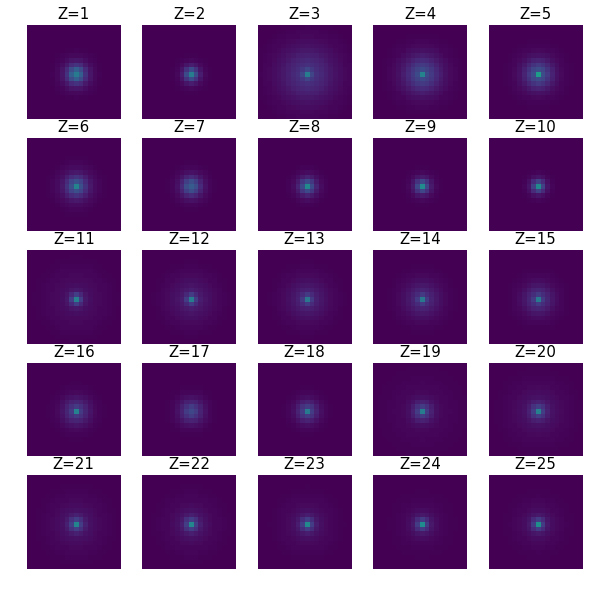

In [3]:
# make a plot of the atomic densities to test them
grid_param = {'grid_spacing':0.3,'grid_size':6, 
                'filter_thresh':1000, 
              'filter_sig':0, 'filter_atomic_core':True}

some_dens = {n:single_atom_dens(n, **grid_param) for n in range( 1,26)}
fig,axs = plt.subplots( 5,5, figsize=(10,10))
atom = 1
for i in range (5):
    for j in range(5):
        axs[i][j].clear()
        axs[i][j].imshow( np.mean(some_dens[atom],0), vmax=atom)
        axs[i][j].set_title( "Z=%d"%atom, fontsize=15)
        axs[i][j].axis('off')
        atom += 1

In [4]:
# this is the molecule loading
traj = mdtraj.load_pdb("2LYZ.pdb")
atoms = list(traj.top.atoms)
atomic_nums = [a.element.atomic_number for a in atoms]
atom_vecs = traj.xyz[0] * 10
atom_vecs -= atom_vecs.mean(0)

unique_atoms = np.unique([a.element.atomic_number for a in atoms] )
unique_atom_dens = {n:single_atom_dens(n, grid_size=4, 
                        grid_spacing=0.2, filter_thresh=1000, 
                        filter_atomic_core=True, filter_sig=0) 
                for n in unique_atoms}

pdb_size = distance.pdist( atom_vecs).max()
print pdb_size
res = grid_param['grid_spacing']
grid_size = int( pdb_size*1.5)
print grid_size
Npt = int(float(grid_size)/res)
vals = np.arange( -Npt/2,Npt/2)*res

print len(atom_vecs)

Atom 6, replacing 0 densities
Atom 7, replacing 1 densities
Atom 8, replacing 0 densities
Atom 16, replacing 0 densities
50.552671461904154
75
1102


In [5]:
# map the molecule to the grid
import sys
dens = np.zeros( (Npt,Npt,Npt), dtype=np.float32)
n = unique_atom_dens[ unique_atom_dens.keys()[0]].shape[0] # size of local atom-density array
for atom_i,(a,Z) in enumerate(zip( atom_vecs, atomic_nums)):
    sys.stdout.flush()
    grid_pt = np.floor( ( a - vals[0]) / res).astype(int)
    pts = tuple( [ np.arange( x-n/2, x+n/2).astype(np.int32) for x in grid_pt])
    x,y,z = np.meshgrid( *pts)
    coors =  (x.ravel(), y.ravel(), z.ravel())

    dens[coors] += unique_atom_dens[Z].ravel()
    nn = len( atomic_nums) - atom_i
    print "\r atoms left: %4d"%(nn-1),
    

 atoms left:    0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

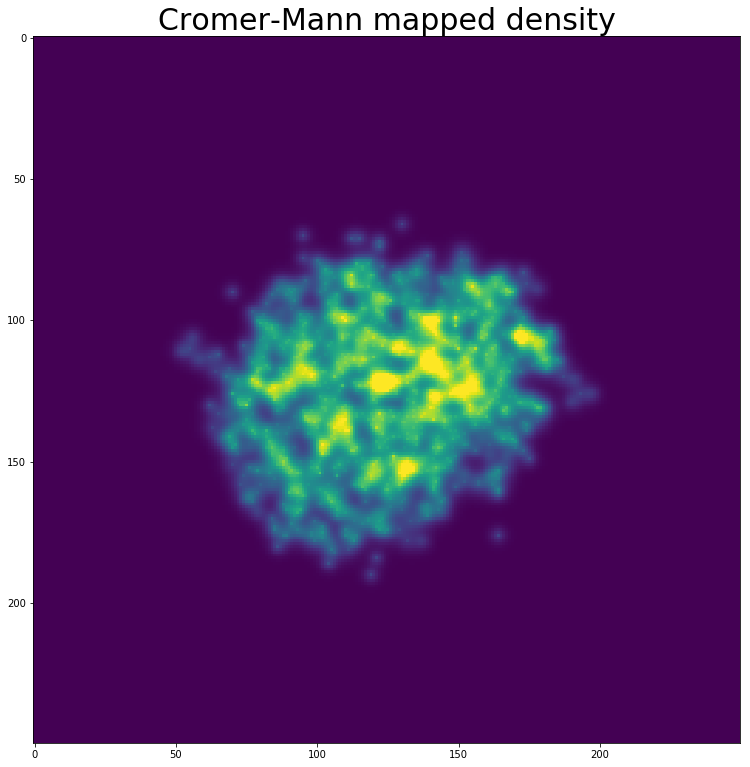

In [6]:
plt.figure(figsize=(13,13))
_=plt.title("Cromer-Mann mapped density", fontsize=30)
_=plt.imshow( dens.mean(0), vmax=2)


In [7]:
%%time
from scipy.fftpack import fftn, fftshift, fftfreq
Nfft = dens.shape[0]*2
diffrac = np.abs(fftshift(fftn(dens, shape=[Nfft,Nfft,Nfft])))**2

/Users/damende/miniconda2/lib/python2.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


CPU times: user 6.52 s, sys: 1.89 s, total: 8.41 s
Wall time: 8.7 s


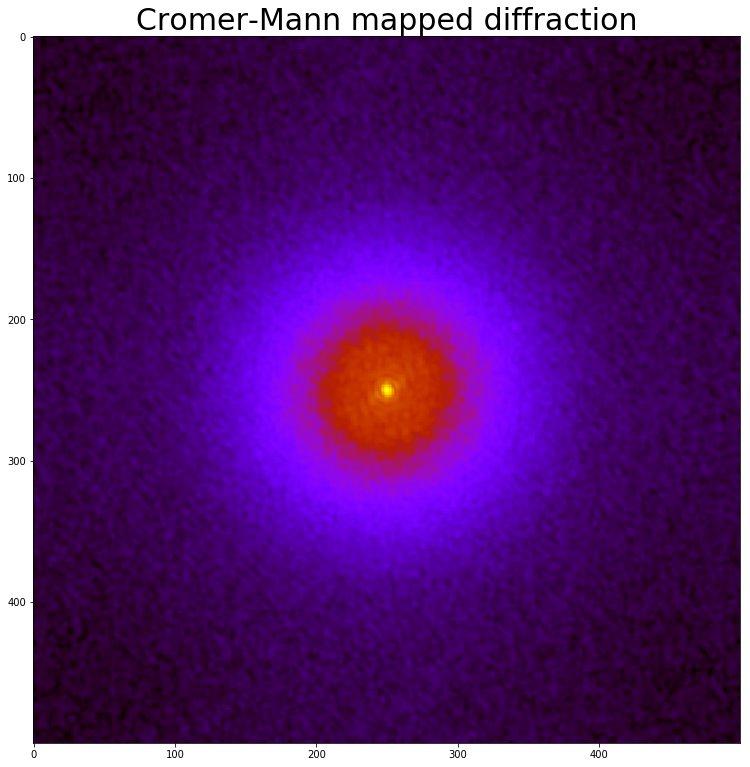

In [8]:
plt.figure(figsize=(13,13))
plt.title("Cromer-Mann mapped diffraction", fontsize=30)
_=plt.imshow( diffrac.mean(0), norm=plt.mpl.colors.LogNorm(), cmap='gnuplot')

In [9]:
from scipy.spatial import cKDTree

#grid_size = grid_param['grid_size'] # angstrom
grid_spacing = grid_param['grid_spacing'] # angstrom
Ngrid_pt = int( float(grid_size)/grid_spacing )

x,y,z = np.mgrid[
        -grid_size/2:grid_size/2:Ngrid_pt*1j, 
        -grid_size/2:grid_size/2:Ngrid_pt*1j, 
        -grid_size/2:grid_size/2:Ngrid_pt*1j]



print("make coors")
coors = np.array( zip(x.ravel(), y.ravel(), z.ravel() ))
print("make tree")
KD_grid = cKDTree(coors)

make coors
make tree


In [10]:
atom_size = 1.5
nearest_gridpts_to_atoms = KD_grid.query_ball_point( atom_vecs, r=atom_size)

dens0 = np.zeros( x.shape)
for i,nearest in enumerate( nearest_gridpts_to_atoms):
    if not nearest:
        continue
    idx = np.unravel_index( nearest, x.shape)
    dens0[idx] += atomic_nums[i]

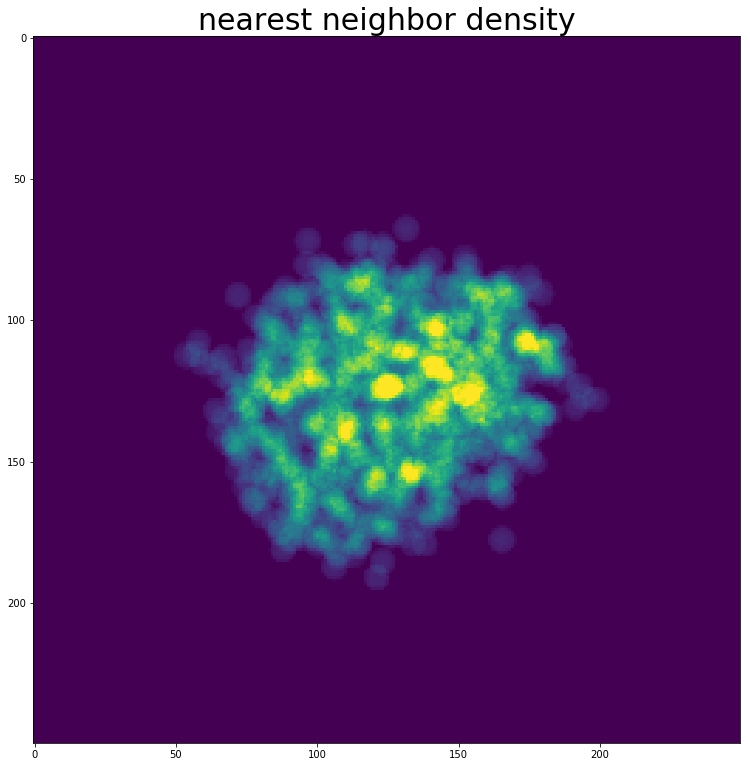

In [11]:
plt.figure(figsize=(13,13))
_=plt.title("nearest neighbor density", fontsize=30)
_=plt.imshow( dens0.mean(0), vmax=3)

In [12]:
%%time
from scipy.fftpack import fftn, fftshift, fftfreq
Nfft = dens.shape[0]*2
diffrac0 = np.abs(fftshift(fftn(dens0, shape=[Nfft,Nfft,Nfft])))**2

CPU times: user 11.2 s, sys: 4.39 s, total: 15.6 s
Wall time: 19.4 s


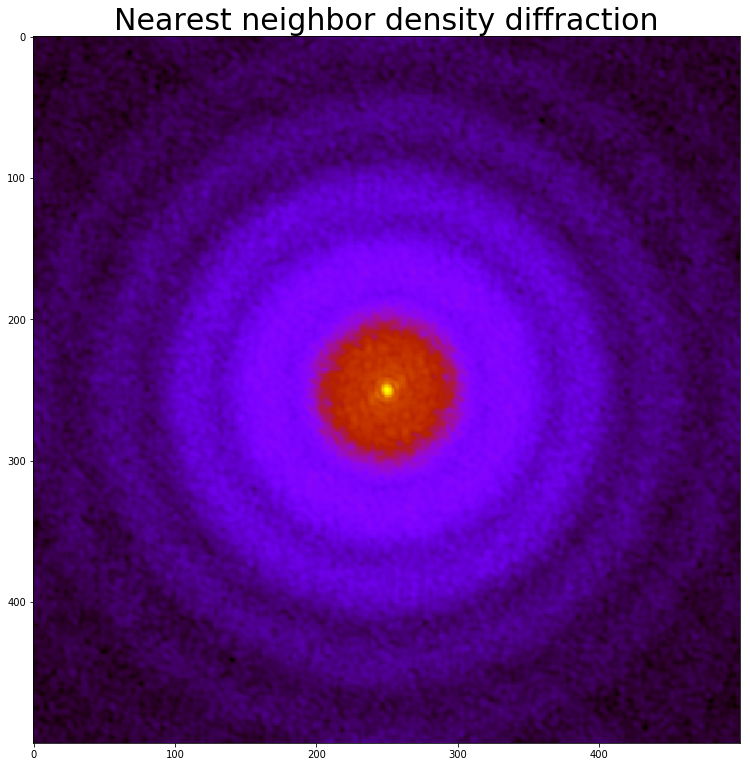

In [13]:
plt.figure(figsize=(13,13))
plt.title("Nearest neighbor density diffraction", fontsize=30)
_=plt.imshow( diffrac0.mean(0), norm=plt.mpl.colors.LogNorm(), cmap='gnuplot')